# Homework 1 - Practical component
##### Nadia Gonzalez Fernandez

In [7]:
import numpy as np
iris = np.genfromtxt('iris.txt')

def draw_rand_label(x, label_list):
	seed = abs(np.sum(x))
	while seed < 1:
		seed = 10 * seed
	seed = int(1000000 * seed)
	np.random.seed(seed)
	return np.random.choice(label_list)

In [8]:
def manhattan_distance(x, p):
	return np.sum(np.abs(x - p))


class HardParzen:
	def __init__(self, h):
		self.label_list = None
		self.h = h
		self.train_inputs = None
		self.train_labels = None
		self.n_classes = None

	def fit(self, train_inputs, train_labels):
		self.label_list = np.unique(train_labels)
		self.train_inputs = train_inputs
		self.train_labels = train_labels
		self.n_classes = len(self.label_list)


	def predict(self, test_data):
		class_predictions = np.zeros(test_data.shape[0])

		for i, current_point in enumerate(test_data):
			count = np.zeros(self.n_classes)

			for j, train_point in enumerate(self.train_inputs):
				distance = manhattan_distance(current_point, train_point)
				if distance < self.h:
					label = int(self.train_labels[j])
					count[label - 1] += 1

			if np.sum(count) == 0:
				class_predictions[i] = draw_rand_label(current_point, self.label_list)
			else:
				class_predictions[i] = np.argmax(count) + 1

		return class_predictions


class SoftRBFParzen:
	def __init__(self, sigma):
		self.sigma  = sigma
		self.label_list = None
		self.train_inputs = None
		self.train_labels = None
		self.n_classes = None

	def fit(self, train_inputs, train_labels):
		self.label_list = np.unique(train_labels)
		self.train_inputs = train_inputs
		self.train_labels = train_labels
		self.n_classes = len(self.label_list)

	def rbf_kernel(self, distance):
		return np.exp(- (distance ** 2) / (2 * self.sigma ** 2))

	def predict(self, test_data):
		class_predictions = np.zeros(test_data.shape[0])

		for i, current_point in enumerate(test_data):
			weights = np.zeros(self.n_classes)

			for j, train_point in enumerate(self.train_inputs):
				distance = manhattan_distance(current_point, train_point)
				current_weight = self.rbf_kernel(distance)
				current_label = int(self.train_labels[j])
				weights[current_label - 1] += current_weight

			class_predictions[i] = np.argmax(weights) + 1

		return class_predictions


def split_dataset(iris):
	training_set = []
	validation_set = []
	test_set = []

	for i in range(len(iris)):
		if i % 5 in [0, 1, 2]:
			training_set.append(iris[i])
		elif i % 5 == 3:
			validation_set.append(iris[i])
		elif i % 5 == 4:
			test_set.append(iris[i])

	training_set = np.array(training_set)
	validation_set = np.array(validation_set)
	test_set = np.array(test_set)

	result = (training_set, validation_set, test_set)
	return result


class ErrorRate:
	def __init__(self, x_train, y_train, x_val, y_val):
		self.x_train = x_train
		self.y_train = y_train
		self.x_val = x_val
		self.y_val = y_val

	def hard_parzen(self, h):
		hp = HardParzen(h)
		hp.fit(self.x_train, self.y_train)
		predictions = hp.predict(self.x_val)
		error_rate = np.mean(predictions != self.y_val)
		return error_rate



	def soft_parzen(self, sigma):
		sp = SoftRBFParzen(sigma)
		sp.fit(self.x_train, self.y_train)
		predictions = sp.predict(self.x_val)
		error_rate = np.mean(predictions != self.y_val)
		return error_rate

In [9]:
import matplotlib.pyplot as plt

### Question 5

Comparing **Hard Parzen** and **RBF Parzen’s** classification error on the validation set of iris
flower, when trained on the training set

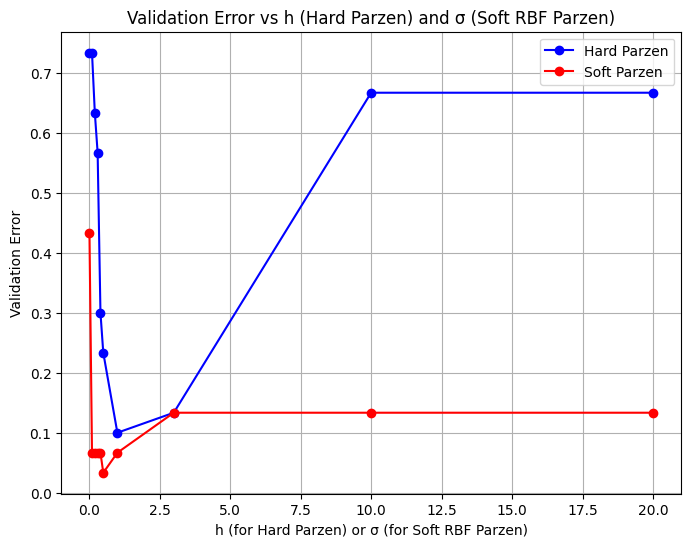

In [11]:
def plot_parzen_validation_errors(iris):
    training_set, validation_set, test_set = split_dataset(iris)
    x_train = training_set[:, :-1]
    y_train = training_set[:, -1]
    x_val = validation_set[:, :-1]
    y_val = validation_set[:, -1]

    error_rate = ErrorRate(x_train, y_train, x_val, y_val)

    h_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    sigma_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]

    validation_errors_hard = []
    validation_errors_soft = []

    for h in h_values:
        error = error_rate.hard_parzen(h)
        validation_errors_hard.append(error)

    for sigma in sigma_values:
        error = error_rate.soft_parzen(sigma)
        validation_errors_soft.append(error)

    plt.figure(figsize=(8, 6))

    plt.plot(h_values, validation_errors_hard, label="Hard Parzen", marker='o', linestyle='-', color='b')

    plt.plot(sigma_values, validation_errors_soft, label="Soft Parzen", marker='o', linestyle='-', color='r')

    plt.xlabel('h (for Hard Parzen) or σ (for Soft RBF Parzen)')
    plt.ylabel('Validation Error')
    plt.title('Validation Error vs h (Hard Parzen) and σ (Soft RBF Parzen)')
    
    plt.legend()

    plt.grid(True)
    plt.show()

plot_parzen_validation_errors(iris)

The previous graph shows two lines representing how the error rates vary with different values of 
$h$ and $σ$

In the **Hard Parzen's Validation Error** initially, with very small values of $h$, the error rate is high because the window is too small to include meaningful neighbors. As $h$ increases, the window grows and can include more relevant neighbors, reducing the error rate. However, after a certain point, further increasing $h$ causes the classifier to include irrelevant neighbors, which increases the error rate.

Similarly, in the **Soft Parzen's Validation Error**, for small $σ$, the RBF kernel heavily weights neighbors that are very close, which may overfit the data. As $σ$ increases, the RBF kernel starts weighing more distant neighbors, leading to better generalization. At very high values of $σ$, the model might start weighing distant and irrelevant neighbors too much, causing a rise in the error rate.

In the graph we can see that Hard Parzen is more sensitive to changes in $h$ because it is based on a fixed window. On the other hand, Soft RBF Parzen tends to generalize better as it uses a kernel function, allowing it to be smoother and less sensitive to sharp boundaries.In most cases, the second algorithm mentioned tends to achieve a lower error rate than the first.

### Question 7

Both Hard Parzen Window and Soft RBF Parzen Window have a time complexity of $O(m*n*d)$, where:

- $m$ is the number of test points,
- $n$ is the number of training points,
- $d$ is the number of features.
For each test point, both methods compute distances to all $n$ training points, with each distance calculation taking $O(d)$. Therefore, the total complexity for $m$ test points is $O(m⋅n⋅d)$.

The hyperparameters $h$ and $σ$ do not affect the complexity of the algorithms, as they influence classification decisions, not the number of operations performed.

### Question 10

In [12]:
def random_projections(X, A):
	projection = (1 / np.sqrt(2)) * np.dot(X, A)
	return projection

In [13]:
def compute_validation_errors(iris, h_values, sigma_values, num_projections=500):
    training_set, validation_set, _ = split_dataset(iris)
    x_train = training_set[:, :-1]
    y_train = training_set[:, -1]
    x_val = validation_set[:, :-1]
    y_val = validation_set[:, -1]
    
    validation_errors_hard = np.zeros((num_projections, len(h_values)))
    validation_errors_soft = np.zeros((num_projections, len(sigma_values)))

    for i in range(num_projections):
        A = np.random.randn(4, 2)
        
        x_train_proj = random_projections(x_train, A)
        x_val_proj = random_projections(x_val, A)

        error_rate = ErrorRate(x_train_proj, y_train, x_val_proj, y_val)

        for j, h in enumerate(h_values):
            validation_errors_hard[i, j] = error_rate.hard_parzen(h)

        for j, sigma in enumerate(sigma_values):
            validation_errors_soft[i, j] = error_rate.soft_parzen(sigma)
    
    mean_errors_hard = np.mean(validation_errors_hard, axis=0)
    std_errors_hard = np.std(validation_errors_hard, axis=0)
    
    mean_errors_soft = np.mean(validation_errors_soft, axis=0)
    std_errors_soft = np.std(validation_errors_soft, axis=0)

    return mean_errors_hard, std_errors_hard, mean_errors_soft, std_errors_soft

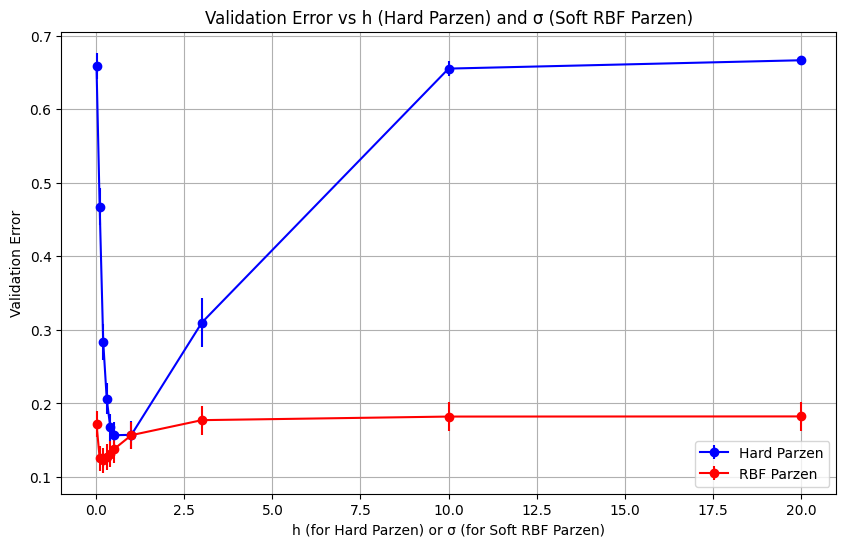

In [14]:

def plot_validation_errors(h_values, sigma_values, mean_errors_hard, std_errors_hard, mean_errors_soft, std_errors_soft):
    """Plot validation errors with error bars."""
    plt.figure(figsize=(10, 6))

    plt.errorbar(h_values, mean_errors_hard, yerr=0.2 * std_errors_hard, label="Hard Parzen", marker='o', linestyle='-', color='b')

    plt.errorbar(sigma_values, mean_errors_soft, yerr=0.2 * std_errors_soft, label="RBF Parzen", marker='o', linestyle='-', color='r')

    plt.xlabel('h (for Hard Parzen) or σ (for Soft RBF Parzen)')
    plt.ylabel('Validation Error')
    plt.title('Validation Error vs h (Hard Parzen) and σ (Soft RBF Parzen)')
    
    plt.legend()

    plt.grid(True)
    plt.show()

h_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
sigma_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]

mean_errors_hard, std_errors_hard, mean_errors_soft, std_errors_soft = compute_validation_errors(iris, h_values, sigma_values)
plot_validation_errors(h_values, sigma_values, mean_errors_hard, std_errors_hard, mean_errors_soft, std_errors_soft)

The graph shows the average validation errors for both **Hard Parzen** and **Soft RBF Parzen** classifiers, with error bars indicating the variability across random projections. 

The plot has a similar behavior to the one without projection. This means that the random projections preserved the essential structure of the data. This suggests that the dimensionality reduction via random projections did not significantly distort the classifier's performance, maintaining comparable trends in validation error as $h$ and $σ$ change.
